<a href="https://colab.research.google.com/github/Tolux5000/Tolux5000/blob/main/1D_Unet_Fresh_to_dried.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets bring in the additives.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the freshAdd.csv data, excluding the first row (assuming it's a header/labels)
print("Loading freshAdd.csv data...")
# Assuming the first row is a header and the data starts from the second row (index 1)
df_fresh_add = pd.read_csv('synthetic_additional.csv')

# Select rwc, K+, and Na+ data (assuming these are in the first three columns: index 0, 1, and 2)
# The user specified only rows 1-102, which corresponds to indices 0-101 in pandas after skipping the header.
additional_data = df_fresh_add.iloc[:200, 0:3].values # [102, 3]


print(f"Shape of additional data: {additional_data.shape}")

# Normalize rwc, K+, and Na+ data together
print("Normalizing rwc, K+, and Na+ data together...")
scaler = MinMaxScaler()
normalized_additional_data = scaler.fit_transform(additional_data) # [102, 3]


print(f"Shape of normalized_additional_data: {normalized_additional_data.shape}")


Loading freshAdd.csv data...
Shape of additional data: (200, 3)
Normalizing rwc, K+, and Na+ data together...
Shape of normalized_additional_data: (200, 3)


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data from the npz file
#data = np.load('synthetic_data_smoothed_and_additional (1).npz')
#spectra = data['synthetic_spectra_smoothed']
#additive_data = data['synthetic_additional']

# Normalize additive data
#scaler = MinMaxScaler()
#normalized_additive_data = scaler.fit_transform(additive_data)

# Separate spectra and additive data
# Assuming the structure is [spectral data, additive data]
spectra1 = pd.read_csv('synthetic_dried_spectra.csv')
spectra2 = pd.read_csv('synthetic_fresh_spectra.csv')
# and additive data is the last 3 columns.
# Split the spectra equally into fresh and dried parts (each with 641 features)
X_fresh = spectra2.iloc[:200,:]
X_dried = spectra1.iloc[:200,:]
ion = additional_data


#np.savetxt('augFresh.csv', X_fresh, delimiter=',')
#np.savetxt('augDried.csv', X_dried, delimiter=',')
#np.savetxt('additives.csv', ion, delimiter=',')



print("Data loaded and processed successfully.")
print(f"Shape of fresh spectra: {X_fresh.shape}")
print(f"Shape of dried spectra: {X_dried.shape}")
print(f"Shape of ion data: {ion.shape}")

Data loaded and processed successfully.
Shape of fresh spectra: (200, 641)
Shape of dried spectra: (200, 641)
Shape of ion data: (200, 3)


This 1D-Unet transforms fresh leaf spectra to dried leaf spectra.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Import F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Checking for GPU... {'GPU available. Using GPU for training.' if torch.cuda.is_available() else 'GPU not available. Using CPU for training.'}")

# 2. Load and Prepare PAIRED Data
print("Loading and preparing paired data...")

# Simulated data for demonstration (replace with your actual CSV files)
# Load from CSV files (assuming first row is wavelengths, rest are samples)
#df_fresh = pd.read_csv('XfreshW.csv').iloc[0:102, :]  # Fresh spectra
#df_dried = pd.read_csv('XdriedW.csv')  # Dried spectra

# Extract data (assuming no header row for wavelengths in this case; adjust if needed)
#X_fresh = df_fresh.to_numpy()  # [num_samples, 640]
#X_dried = df_dried.to_numpy()  # [num_samples, 640]
num_samples, num_wavelengths = X_fresh.shape

# Load and normalize additional data (moved from previous cell)
print("Loading ion data...")
#df_fresh_add = pd.read_csv('freshAdd.csv', header=None)
additional_data = ion #df_fresh_add.iloc[0:num_samples, 0:3].values # Use num_samples to match spectral data


Checking for GPU... GPU not available. Using CPU for training.
Loading and preparing paired data...
Loading ion data...


Shape of additional data: (200, 3)
Normalizing rwc, K+, and Na+ data together...
Shape of normalized_additional_data: (200, 3)
Data split: 160 training samples, 40 test samples
Epoch [1/300], Train Loss: 1.3706, Val Loss: 1.4295
Epoch [21/300], Train Loss: 0.9675, Val Loss: 0.9074
Early stopping triggered
Making predictions on test set...
Overall Test MSE (Spectral Data Only): 0.0006
Overall Test RMSE (Spectral Data Only): 0.0241


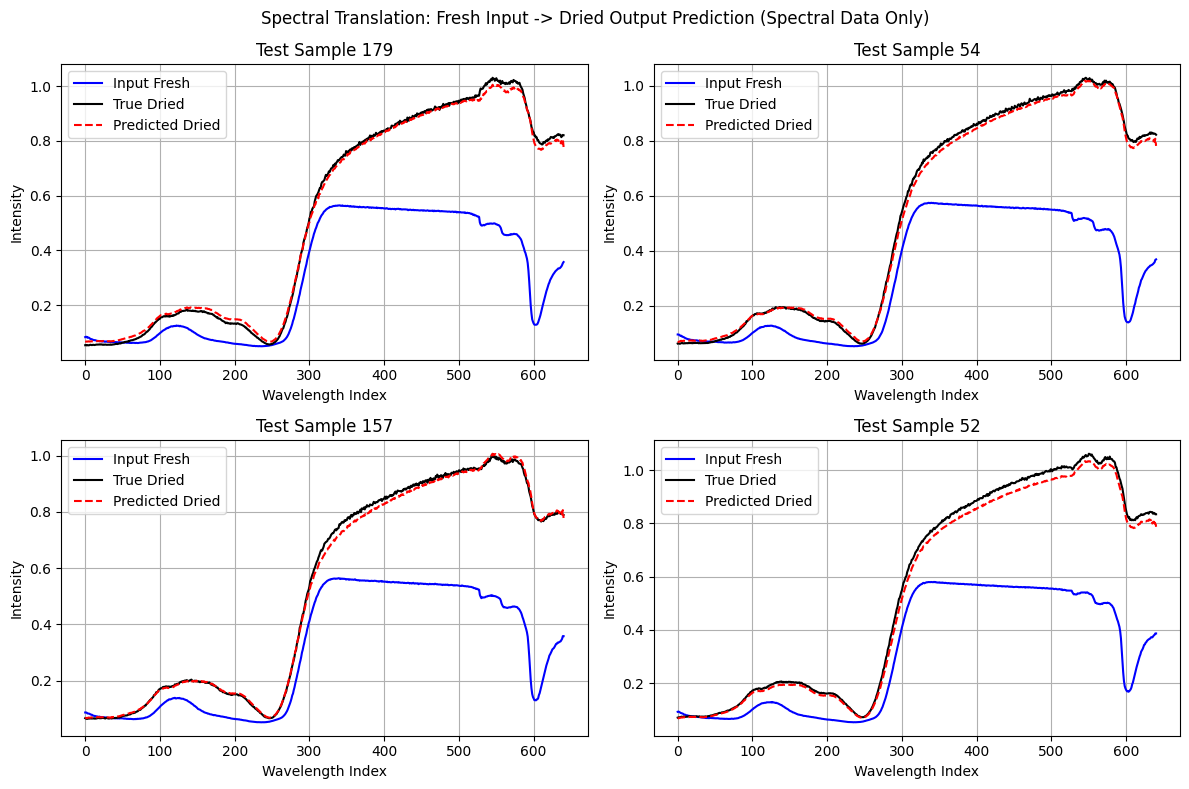

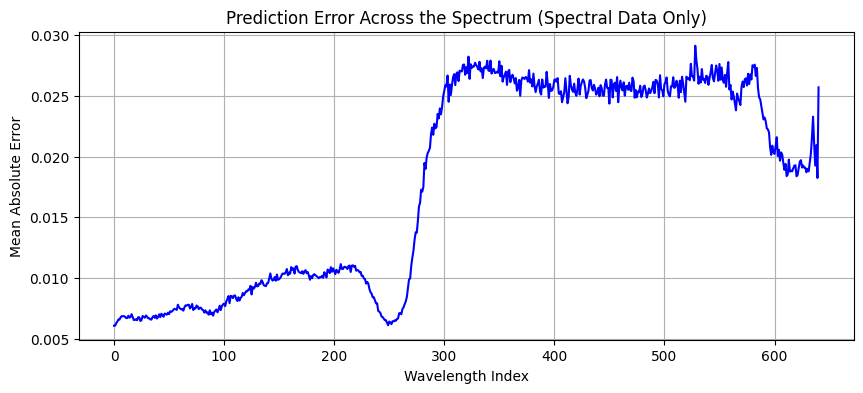

Model and spectral predictions saved to unet_model.pth and predictions.npz


In [6]:
print(f"Shape of additional data: {additional_data.shape}")

# Normalize rwc, K+, and Na+ data together
print("Normalizing rwc, K+, and Na+ data together...")
scaler = MinMaxScaler()
normalized_additional_data = additional_data # scaler.fit_transform(additional_data) # [num_samples, 3]
print(f"Shape of normalized_additional_data: {normalized_additional_data.shape}")


# Split into training and test sets (80/20 split)
train_ratio = 0.8
num_samples = X_fresh.shape[0]  # Ensure num_samples is correct based on actual data
num_train = int(train_ratio * num_samples)
indices = np.random.permutation(num_samples)
train_idx = indices[:num_train]
test_idx = indices[num_train:]

# Calculate normalization parameters from training data
fresh_mean = np.mean(X_fresh.iloc[train_idx], axis=0)
fresh_std = np.std(X_fresh.iloc[train_idx], axis=0)
dried_mean = np.mean(X_dried.iloc[train_idx], axis=0)
dried_std = np.std(X_dried.iloc[train_idx], axis=0)

# Apply normalization
X_fresh_norm = (X_fresh - fresh_mean) / fresh_std
X_dried_norm = (X_dried - dried_mean) / dried_std

# Concatenate additional data
# Ensure the number of samples matches
if normalized_additional_data.shape[0] != num_samples:
    raise ValueError("Number of samples in additional data does not match spectral data.")

# Concatenate the normalized additional data to the normalized spectral data
X_fresh_norm_concat = np.concatenate((X_fresh_norm, normalized_additional_data), axis=1)
X_dried_norm_concat = np.concatenate((X_dried_norm, normalized_additional_data), axis=1)


# Split into training and test sets
X_train = torch.tensor(X_fresh_norm_concat[train_idx], dtype=torch.float32)
Y_train = torch.tensor(X_dried_norm_concat[train_idx], dtype=torch.float32)
X_test = torch.tensor(X_fresh_norm_concat[test_idx], dtype=torch.float32)
Y_test = torch.tensor(X_dried_norm_concat[test_idx], dtype=torch.float32)


print(f"Data split: {num_train} training samples, {num_samples - num_train} test samples")

# Reshape data for 1D CNN input: [batch_size, channels, sequence_length]
# The sequence length will now be num_wavelengths + num_additional_features
input_length = num_wavelengths + normalized_additional_data.shape[1]
X_train = X_train.unsqueeze(1)  # [num_train, 1, input_length]
Y_train = Y_train.unsqueeze(1)  # [num_train, 1, input_length]
X_test = X_test.unsqueeze(1)  # [num_test, 1, input_length]
Y_test = Y_test.unsqueeze(1)  # [num_test, 1, input_length]

# Create DataLoader
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 4. Define 1D U-Net Model Architecture
class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, input_length=input_length): # Adjust input length dynamically
        super(UNet1D, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv1d(in_channels, 32, kernel_size=5, padding=2)
        self.enc_bn1 = nn.BatchNorm1d(32)
        self.enc_conv2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.enc_bn2 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.enc_bn3 = nn.BatchNorm1d(64)
        self.enc_conv4 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.enc_bn4 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2, stride=2)

        self.bottleneck_conv1 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bottleneck_bn1 = nn.BatchNorm1d(128)
        self.bottleneck_conv2 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.bottleneck_bn2 = nn.BatchNorm1d(128)

        # Decoder
        # Removed dynamic output_padding calculation
        self.upconv1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up_bn1 = nn.BatchNorm1d(64)
        self.dec_conv1 = nn.Conv1d(128, 64, kernel_size=5, padding=2)
        self.dec_bn2 = nn.BatchNorm1d(64)

        self.upconv2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up_bn3 = nn.BatchNorm1d(32)
        self.dec_conv2 = nn.Conv1d(64, 32, kernel_size=5, padding=2)
        self.dec_bn4 = nn.BatchNorm1d(32)

        self.final_conv1 = nn.Conv1d(32, 16, kernel_size=5, padding=2)
        self.final_bn1 = nn.BatchNorm1d(16)
        self.final_conv2 = nn.Conv1d(16, out_channels, kernel_size=1)

        self.dropout = nn.Dropout(0.2)  # Regularization

    def forward(self, x):
        # Encoder
        e1 = self.dropout(F.leaky_relu(self.enc_bn1(self.enc_conv1(x)), 0.1))
        e2 = self.dropout(F.leaky_relu(self.enc_bn2(self.enc_conv2(e1)), 0.1))
        p1 = self.pool1(e2)

        e3 = self.dropout(F.leaky_relu(self.enc_bn3(self.enc_conv3(p1)), 0.1))
        e4 = self.dropout(F.leaky_relu(self.enc_bn4(self.enc_conv4(e3)), 0.1))
        p2 = self.pool1(e4)

        b = self.dropout(F.leaky_relu(self.bottleneck_bn1(self.bottleneck_conv1(p2)), 0.1))
        b = self.dropout(F.leaky_relu(self.bottleneck_bn2(self.bottleneck_conv2(b)), 0.1))

        # Decoder
        # Removed dynamic output_padding calculation
        d1 = self.dropout(F.leaky_relu(self.up_bn1(self.upconv1(b)), 0.1))
        # Pad d1 to match the size of e4
        padding1 = e4.shape[-1] - d1.shape[-1]
        if padding1 > 0:
            d1 = F.pad(d1, (0, padding1))
        d1 = torch.cat([d1, e4], dim=1)  # Skip connection
        d1 = self.dropout(F.leaky_relu(self.dec_bn2(self.dec_conv1(d1)), 0.1))

        d2 = self.dropout(F.leaky_relu(self.up_bn3(self.upconv2(d1)), 0.1))
        # Pad d2 to match the size of e2
        padding2 = e2.shape[-1] - d2.shape[-1]
        if padding2 > 0:
             d2 = F.pad(d2, (0, padding2))
        d2 = torch.cat([d2, e2], dim=1)  # Skip connection
        d2 = self.dropout(F.leaky_relu(self.dec_bn4(self.dec_conv2(d2)), 0.1))

        out = self.dropout(F.leaky_relu(self.final_bn1(self.final_conv1(d2)), 0.1))
        out = self.final_conv2(out)
        return out

# Initialize model
model = UNet1D(input_length=input_length).to(device) # Pass the calculated input_length
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-3)  # L2 regularization

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10) # Removed verbose=True

# 5. Enhanced Training Options with Augmentation
def augment_spectra(X, Y, augmentation_factor=0.01):
    X_aug = X.clone()
    Y_aug = Y.clone()
    for i in range(X.size(0)):
        if np.random.rand() < augmentation_factor:
            noise_level = 0.02 + 0.03 * np.random.rand()
            X_aug[i, :, :num_wavelengths] = X[i, :, :num_wavelengths] + noise_level * torch.randn_like(X[i, :, :num_wavelengths])
            scale = 0.9 + 0.2 * np.random.rand()
            X_aug[i, :, :num_wavelengths] = X_aug[i, :, :num_wavelengths] * scale
            Y_aug[i, :, :num_wavelengths] = Y[i, :, :num_wavelengths] * scale
    return X_aug, Y_aug

# Training loop
num_epochs = 300
best_loss = float('inf')
patience = 30 # Increased patience for scheduler
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Augment data
        X_aug, Y_aug = augment_spectra(X_batch, Y_batch)

        optimizer.zero_grad()
        outputs = model(X_aug)
        loss = criterion(outputs, Y_aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, Y_batch).item()
    val_loss = val_loss / len(test_loader)

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    if epoch % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'unet_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load best model
model.load_state_dict(torch.load('unet_model.pth'))

# 7. Evaluate the Model & Visualize Predictions
print("Making predictions on test set...")
model.eval()
Y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        Y_pred.append(outputs.cpu().numpy())

Y_pred = np.concatenate(Y_pred, axis=0)

# Denormalize and remove additional data part
# The first num_wavelengths columns are the spectral data
Y_pred_denorm_spectral = (Y_pred.squeeze()[:, :num_wavelengths] * dried_std.to_numpy()) + dried_mean.to_numpy()
Y_test_denorm_spectral = (Y_test.squeeze().numpy()[:, :num_wavelengths] * dried_std.to_numpy()) + dried_mean.to_numpy()
X_test_denorm_spectral = (X_test.squeeze().numpy()[:, :num_wavelengths] * fresh_std.to_numpy()) + fresh_mean.to_numpy()


# Calculate MSE and RMSE on spectral data only
mse = np.mean((Y_pred_denorm_spectral - Y_test_denorm_spectral) ** 2)
rmse = np.sqrt(mse)
print(f"Overall Test MSE (Spectral Data Only): {mse:.4f}")
print(f"Overall Test RMSE (Spectral Data Only): {rmse:.4f}")

# Plot a few random test samples (spectral data only)
num_plots = min(4, len(test_idx))
random_indices = np.random.choice(len(test_idx), num_plots, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(2, 2, i)
    plt.plot(X_test_denorm_spectral[idx], 'b-', label='Input Fresh')
    plt.plot(Y_test_denorm_spectral[idx], 'k-', label='True Dried')
    plt.plot(Y_pred_denorm_spectral[idx], 'r--', label='Predicted Dried')
    plt.title(f'Test Sample {test_idx[idx]}')
    plt.xlabel('Wavelength Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
plt.suptitle('Spectral Translation: Fresh Input -> Dried Output Prediction (Spectral Data Only)')
plt.tight_layout()
plt.show()

# Plot mean absolute error per wavelength (spectral data only)
mean_abs_error = np.mean(np.abs(Y_pred_denorm_spectral - Y_test_denorm_spectral), axis=0)
plt.figure(figsize=(10, 4))
plt.plot(mean_abs_error, 'b-', linewidth=1.5)
plt.xlabel('Wavelength Index')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Error Across the Spectrum (Spectral Data Only)')
plt.grid(True)
plt.show()


# Save model and predictions
torch.save(model.state_dict(), 'unet_model.pth')
np.savez('predictions.npz', Y_pred_denorm_spectral=Y_pred_denorm_spectral, Y_test_denorm_spectral=Y_test_denorm_spectral, X_test_denorm_spectral=X_test_denorm_spectral)
print("Model and spectral predictions saved to unet_model.pth and predictions.npz")

In [ ]:
print(f"Shape of X_fresh: {X_fresh.shape}")
print(f"Shape of X_dried: {X_dried.shape}")
print(f"Shape of normalized_additional_data: {normalized_additional_data.shape}")

Shape of X_fresh: (1000, 641)
Shape of X_dried: (1000, 641)
Shape of normalized_additional_data: (1000, 3)


# Task
Write a PLSR code that predicts the first column of "ions.csv" using the best and minimum features possible. Transform all the data in Xfresh.csv to their dried spectra using the Unet model in the previous code. Compare the accuracy of both the Xfresh.csv and the predicted data. Print the number of features used and the accuracy for both models and compare their performance.

## Load data

### Subtask:
Load the 'ions.csv' file and the original fresh spectra data ('Xfresh.csv').


**Reasoning**:
Load the 'ions.csv' and 'Xfresh.csv' files into pandas DataFrames.



In [29]:
df_ions = pd.read_csv('synthetic_additional.csv')
df_fresh_original = pd.read_csv('synthetic_fresh_spectra.csv')

## Predict dried spectra

### Subtask:
Use the trained UNet model to predict the dried spectra for the entire original fresh spectra dataset ('Xfresh.csv').


In [30]:
# Assuming the trained 'model' from the previous cells is available and loaded
# Assuming 'device' is defined (cuda or cpu)
# Assuming 'fresh_mean', 'fresh_std', 'dried_mean', 'dried_std' are available (normalization parameters)
# Assuming 'num_wavelengths' is available


print("Predicting dried spectra for the entire Xfresh.csv dataset...")

# Load the original fresh spectra data
# Assuming df_fresh_original is already loaded in a previous cell
# df_fresh_original = pd.read_csv('XfreshW.csv') # Already loaded in 499a2b54

# Convert original fresh spectra to tensor
X_fresh_original_tensor = torch.tensor(df_fresh_original.to_numpy(), dtype=torch.float32)

# Load and prepare additional data for concatenation
# Assuming df_fresh_add contains the additional data and is already loaded (should be synthetic_additional.csv based on cell igFtOCUjadQj)
# Ensure the number of samples matches X_fresh_original_tensor
num_original_samples = X_fresh_original_tensor.shape[0]
additional_data_original = df_fresh_add.iloc[:num_original_samples, 0:3].values # Use the first num_original_samples rows

# Initialize and fit the MinMaxScaler on the additional data used during training
scaler = MinMaxScaler()
# Assuming 'additional_data' from cell 'weW3nl36NPGe' is the data the scaler should be fitted on
scaler.fit(additional_data)

# Normalize additional data using the fitted scaler
normalized_additional_data_original = scaler.transform(additional_data_original)

# Convert normalized_additional_data_original to tensor
normalized_additional_data_original_tensor = torch.tensor(normalized_additional_data_original, dtype=torch.float32)

# Normalize the spectral part using fresh_mean and fresh_std
fresh_mean_tensor = torch.tensor(fresh_mean.to_numpy(), dtype=torch.float32)
fresh_std_tensor = torch.tensor(fresh_std.to_numpy(), dtype=torch.float32)

X_fresh_original_spectral_norm = (X_fresh_original_tensor - fresh_mean_tensor) / fresh_std_tensor

# Concatenate the normalized spectral data with the normalized additional data
X_fresh_original_norm_concat = torch.cat((X_fresh_original_spectral_norm, normalized_additional_data_original_tensor), dim=1)


# Reshape for model input: [batch_size, channels, sequence_length]
X_fresh_original_norm_concat = X_fresh_original_norm_concat.unsqueeze(1)


# Move to device and ensure correct data type
X_fresh_original_norm_concat = X_fresh_original_norm_concat.to(device)

# Set model to evaluation mode
model.eval()

# Perform prediction
with torch.no_grad():
    Y_predicted_dried_norm_concat = model(X_fresh_original_norm_concat)

# Move prediction back to CPU and convert to numpy
Y_predicted_dried_norm_concat = Y_predicted_dried_norm_concat.cpu().numpy()

# Denormalize the predicted dried spectra (only the spectral part)
# The predicted output also has the concatenated additional data, so we need to slice it
Y_predicted_dried_norm_spectral = Y_predicted_dried_norm_concat.squeeze()[:, :num_wavelengths]

# Denormalize using dried_mean and dried_std
dried_mean_tensor = torch.tensor(dried_mean.to_numpy(), dtype=torch.float32)
dried_std_tensor = torch.tensor(dried_std.to_numpy(), dtype=torch.float32)

X_predicted_dried = (Y_predicted_dried_norm_spectral * dried_std_tensor.numpy()) + dried_mean_tensor.numpy()


print("Predicted dried spectra for the entire fresh dataset generated and denormalized.")

# Save X_predicted_dried as a CSV file
np.savetxt('transformedF2D.csv', X_predicted_dried, delimiter=',')
print("Predicted dried spectra saved as transformedF2D.csv")

Predicting dried spectra for the entire Xfresh.csv dataset...
Predicted dried spectra for the entire fresh dataset generated and denormalized.
Predicted dried spectra saved as transformedF2D.csv


Plotting the Input and Predicted spectra below.

Plotting original fresh and predicted dried spectra...


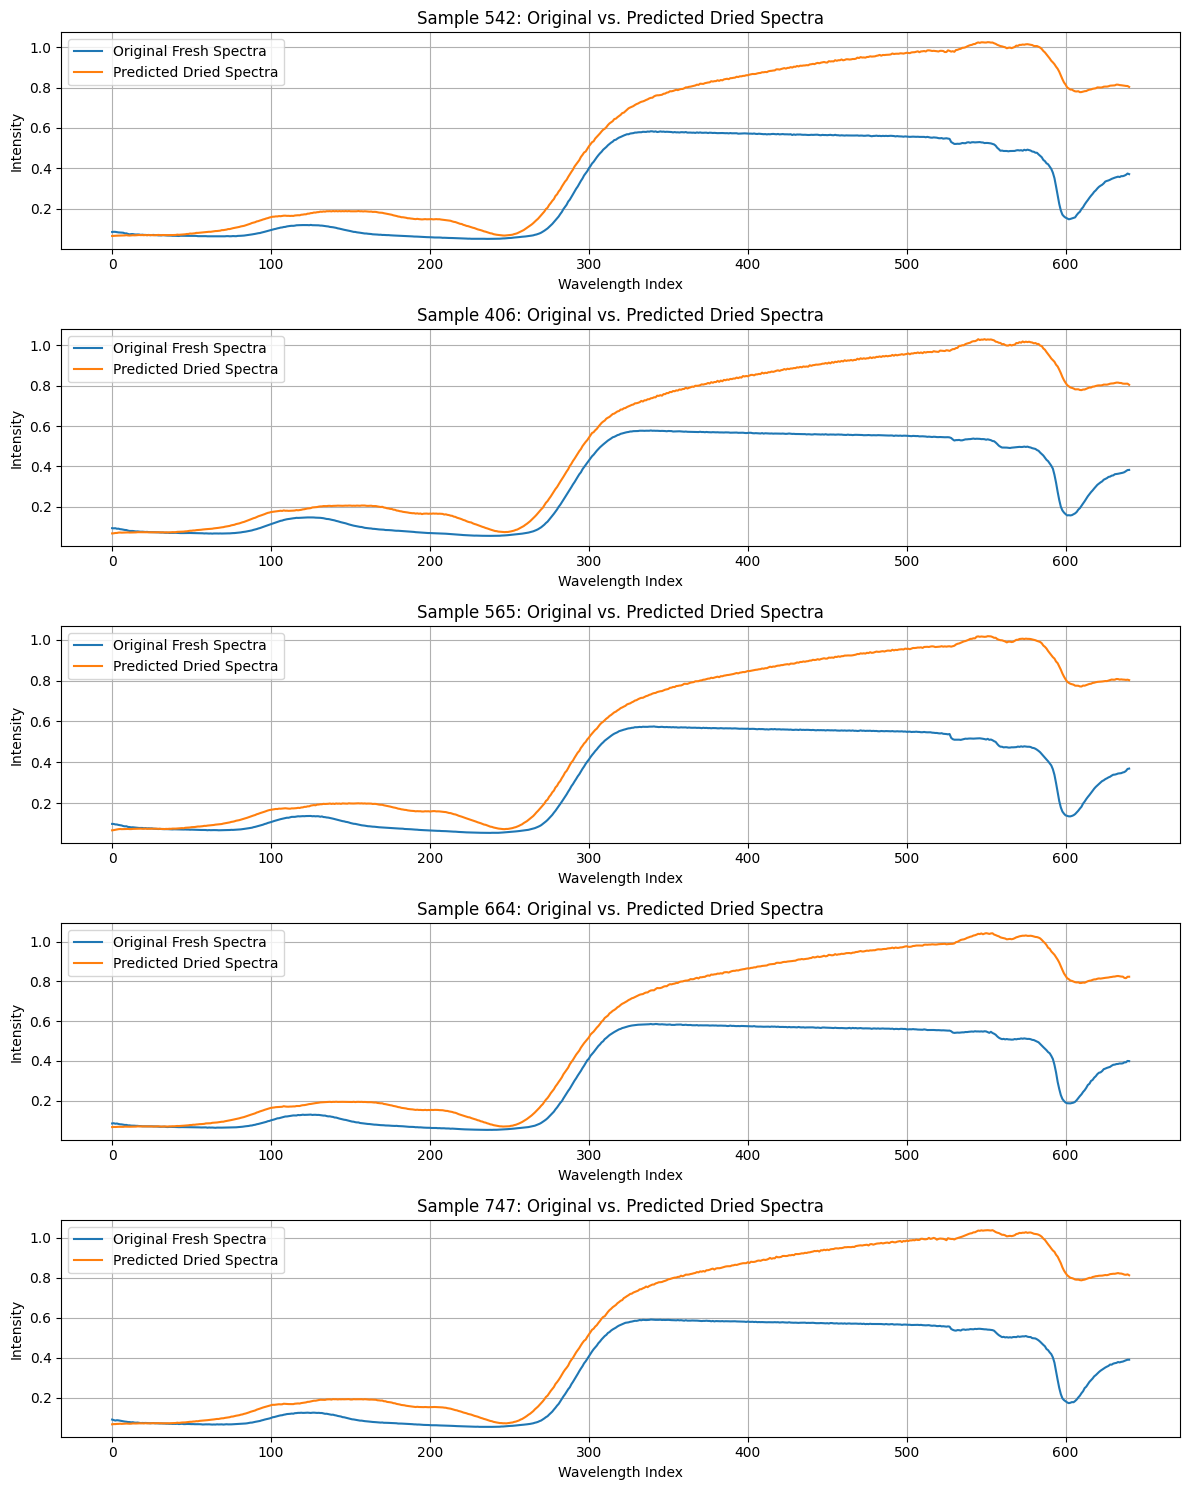

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_fresh_original_tensor and X_predicted_dried are available from previous cells

print("Plotting original fresh and predicted dried spectra...")

# Convert X_fresh_original_tensor to numpy for plotting
X_fresh_original_np = X_fresh_original_tensor.numpy()

# Select a few random samples to plot
num_plots = min(5, X_fresh_original_np.shape[0]) # Plot up to 5 samples or fewer if less data is available
random_indices = np.random.choice(X_fresh_original_np.shape[0], num_plots, replace=False)

plt.figure(figsize=(12, num_plots * 3)) # Adjust figure size based on number of plots

for i, idx in enumerate(random_indices):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(X_fresh_original_np[idx], label='Original Fresh Spectra')
    plt.plot(X_predicted_dried[idx], label='Predicted Dried Spectra')
    plt.title(f'Sample {idx+1}: Original vs. Predicted Dried Spectra')
    plt.xlabel('Wavelength Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
Perform PCA on the transposed spectra.
Smooth the transposed spectra.
Compare the results.
Explore other options of improving the transposed spectra. (Like trying PCA before training.)

## Prepare Data

### Subtask:
Extract the target variable from 'ions.csv' and create feature matrices for the original fresh and predicted dried spectra. Ensure the number of samples matches.

**Reasoning**:
Extract the first column of `df_ions` as the target variable (Y) and use `df_fresh_original` as the feature matrix for the original fresh spectra (X_fresh). Use the predicted dried spectra (`X_predicted_dried`) as the feature matrix for the predicted dried spectra (X_dried_predicted). Since the UNet model was trained on 101 samples from the fresh and dried datasets, and the `ions.csv` file has 150 samples, I need to ensure that I only use the first 101 samples from the `ions.csv` file to match the number of samples in the spectral data.

In [38]:
# Extract the target variable (first column of ions.csv)
Y = df_ions.iloc[:, 2].to_numpy() # Use only the first 'num_samples' rows to match spectral data



# Use predicted dried spectra as X_dried_predicted
X_dried_predicted = X_predicted_dried
X_fresh = X_fresh_original_tensor.numpy()
# Print the shapes to confirm they match
print(f"Shape of X_fresh: {X_fresh.shape}")
print(f"Shape of X_dried_predicted: {X_dried_predicted.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X_fresh: (1000, 641)
Shape of X_dried_predicted: (1000, 641)
Shape of Y: (1000,)


Lets test the transposed data with PLSR

Performing PLSR on synthetic fresh and dried spectra to predict Na+...
Shape of synthetic_fresh_spectra: (1000, 641)
Shape of synthetic_dried_spectra: (1000, 641)
Shape of synthetic_na_plus: (1000,)

=== PLSR for Synthetic Fresh Spectra (Predicting Na+) ===


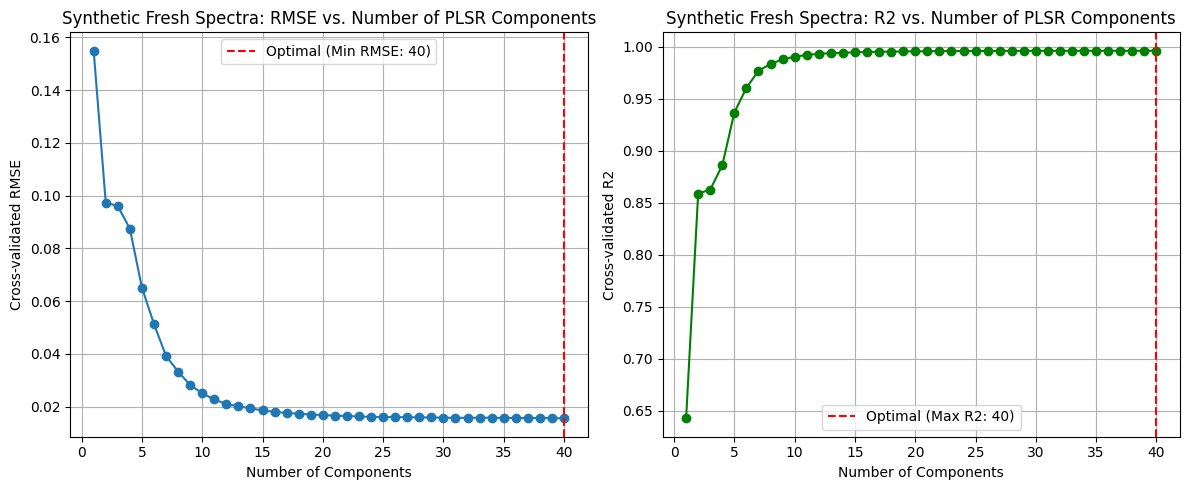


--- Synthetic Fresh Spectra Results based on Minimum RMSE ---
Optimal number of components (Min RMSE): 40
Minimum cross-validated RMSE: 0.0156
R2 at minimum RMSE: 0.9964

--- Synthetic Fresh Spectra Results based on Maximum R2 ---
Optimal number of components (Max R2): 40
Maximum cross-validated R2: 0.9964
RMSE at maximum R2: 0.0156


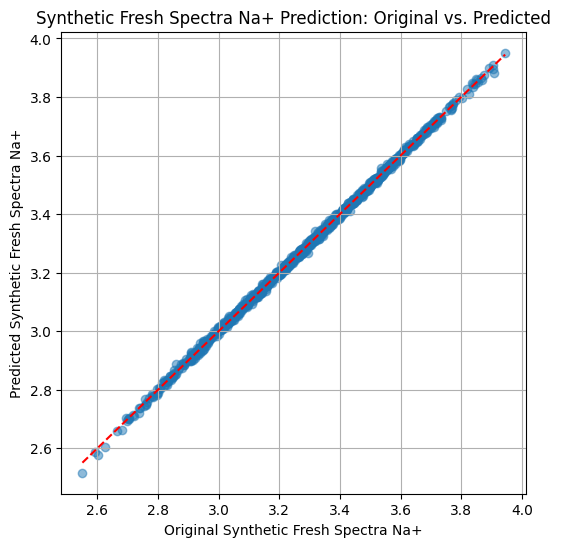


Synthetic Fresh Spectra PLSR Results:
Optimal Components (Min RMSE): 40, RMSE: 0.0156, R2: 0.9964
Optimal Components (Max R2): 40, R2: 0.9964, RMSE: 0.0156

=== PLSR for Synthetic Dried Spectra (Predicting Na+) ===


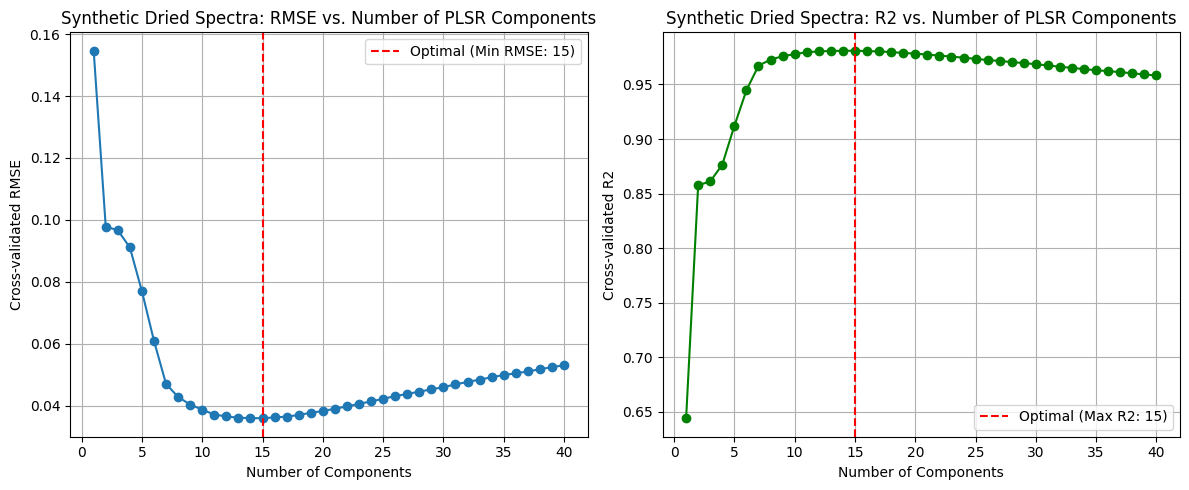


--- Synthetic Dried Spectra Results based on Minimum RMSE ---
Optimal number of components (Min RMSE): 15
Minimum cross-validated RMSE: 0.0359
R2 at minimum RMSE: 0.9809

--- Synthetic Dried Spectra Results based on Maximum R2 ---
Optimal number of components (Max R2): 15
Maximum cross-validated R2: 0.9809
RMSE at maximum R2: 0.0359


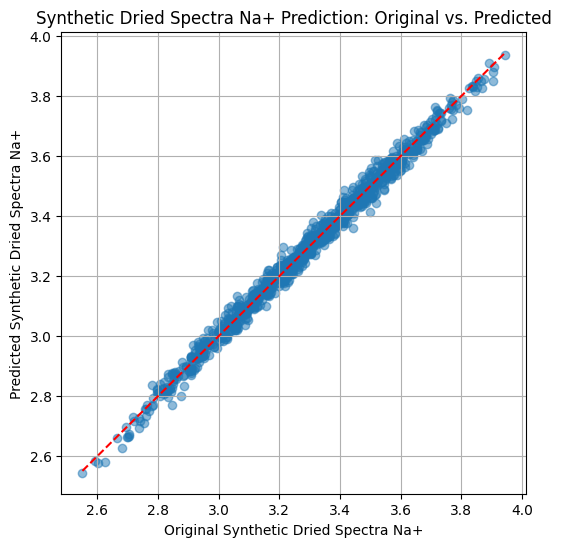


Synthetic Dried Spectra PLSR Results:
Optimal Components (Min RMSE): 15, RMSE: 0.0359, R2: 0.9809
Optimal Components (Max R2): 15, R2: 0.9809, RMSE: 0.0359


In [39]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'synthetic_spectra' and 'synthetic_additional' are available from previous cells
# If not, you might need to load them from the saved .npz file.

print("Performing PLSR on synthetic fresh and dried spectra to predict Na+...")

# Separate synthetic fresh and dried spectra and Na+ data
synthetic_fresh_spectra = X_fresh # [num_synthetic, 641]
synthetic_dried_spectra = X_dried_predicted # [num_synthetic, 641]
synthetic_na_plus = Y  # [num_synthetic,] # Assuming Na+ is the last column (index 2)

print(f"Shape of synthetic_fresh_spectra: {synthetic_fresh_spectra.shape}")
print(f"Shape of synthetic_dried_spectra: {synthetic_dried_spectra.shape}")
print(f"Shape of synthetic_na_plus: {synthetic_na_plus.shape}")


# Function to perform PLSR with cross-validation, find optimal components, and plot results
def find_optimal_plsr_components(X, y, max_components=40, n_splits=5, data_label="Data"): # Reduced max_components
    # Limit max_components to be at most the number of samples
    if max_components is None or max_components > X.shape[0]:
        max_components = X.shape[0]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse_scores = []
    r2_scores = []

    # Ensure we don't try more components than available features or samples in a fold
    max_possible_components = min(X.shape[1], X.shape[0] - X.shape[0] // n_splits) # Approx samples in training fold
    search_limit = min(max_components, max_possible_components)

    for n_comp in range(1, search_limit + 1):
        plsr = PLSRegression(n_components=n_comp)
        fold_rmse = []
        fold_r2 = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            plsr.fit(X_train, y_train)
            y_pred = plsr.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            fold_rmse.append(rmse)
            fold_r2.append(r2)

        rmse_scores.append(np.mean(fold_rmse))
        r2_scores.append(np.mean(fold_r2))

    # Find the number of components with the minimum RMSE
    optimal_components_rmse = np.argmin(rmse_scores) + 1
    min_rmse = np.min(rmse_scores)
    corresponding_r2_rmse = r2_scores[optimal_components_rmse - 1]

    # Find the number of components with the maximum R2
    optimal_components_r2 = np.argmax(r2_scores) + 1
    max_r2 = np.max(r2_scores)
    corresponding_rmse_r2 = rmse_scores[optimal_components_r2 - 1]

    # Plot RMSE and R2 vs number of components
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, search_limit + 1), rmse_scores, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cross-validated RMSE')
    plt.title(f'{data_label}: RMSE vs. Number of PLSR Components')
    plt.grid(True)
    plt.axvline(x=optimal_components_rmse, color='r', linestyle='--', label=f'Optimal (Min RMSE: {optimal_components_rmse})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, search_limit + 1), r2_scores, marker='o', color='green')
    plt.xlabel('Number of Components')
    plt.ylabel('Cross-validated R2')
    plt.title(f'{data_label}: R2 vs. Number of PLSR Components')
    plt.grid(True)
    plt.axvline(x=optimal_components_r2, color='r', linestyle='--', label=f'Optimal (Max R2: {optimal_components_r2})')
    plt.legend()

    plt.tight_layout()
    plt.show()


    print(f"\n--- {data_label} Results based on Minimum RMSE ---")
    print(f"Optimal number of components (Min RMSE): {optimal_components_rmse}")
    print(f"Minimum cross-validated RMSE: {min_rmse:.4f}")
    print(f"R2 at minimum RMSE: {corresponding_r2_rmse:.4f}")

    print(f"\n--- {data_label} Results based on Maximum R2 ---")
    print(f"Optimal number of components (Max R2): {optimal_components_r2}")
    print(f"Maximum cross-validated R2: {max_r2:.4f}")
    print(f"RMSE at maximum R2: {corresponding_rmse_r2:.4f}")

    # Perform final PLSR fit using the optimal number of components (based on min RMSE)
    final_plsr = PLSRegression(n_components=optimal_components_rmse)
    final_plsr.fit(X, y)
    y_pred_final = final_plsr.predict(X)

    # Plot original vs predicted values
    plt.figure(figsize=(6, 6))
    plt.scatter(y, y_pred_final, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') # Add a diagonal line
    plt.xlabel(f'Original {data_label} Na+')
    plt.ylabel(f'Predicted {data_label} Na+')
    plt.title(f'{data_label} Na+ Prediction: Original vs. Predicted')
    plt.grid(True)
    plt.show()


    # Return the optimal components and metrics
    return optimal_components_rmse, min_rmse, corresponding_r2_rmse, optimal_components_r2, max_r2, corresponding_rmse_r2


# --- PLSR for Synthetic Fresh Spectra ---
print("\n=== PLSR for Synthetic Fresh Spectra (Predicting Na+) ===")
optimal_comp_fresh_rmse, min_rmse_fresh, r2_at_min_rmse_fresh, optimal_comp_fresh_r2, max_r2_fresh, rmse_at_max_r2_fresh = \
    find_optimal_plsr_components(synthetic_fresh_spectra, synthetic_na_plus, data_label="Synthetic Fresh Spectra")

# Explicitly print the returned results for fresh spectra
print("\nSynthetic Fresh Spectra PLSR Results:")
print(f"Optimal Components (Min RMSE): {optimal_comp_fresh_rmse}, RMSE: {min_rmse_fresh:.4f}, R2: {r2_at_min_rmse_fresh:.4f}")
print(f"Optimal Components (Max R2): {optimal_comp_fresh_r2}, R2: {max_r2_fresh:.4f}, RMSE: {rmse_at_max_r2_fresh:.4f}")


# --- PLSR for Synthetic Dried Spectra ---
print("\n=== PLSR for Synthetic Dried Spectra (Predicting Na+) ===")
optimal_comp_dried_rmse, min_rmse_dried, r2_at_min_rmse_dried, optimal_comp_dried_r2, max_r2_dried, rmse_at_max_r2_dried = \
    find_optimal_plsr_components(synthetic_dried_spectra, synthetic_na_plus, data_label="Synthetic Dried Spectra")

# Explicitly print the returned results for dried spectra
print("\nSynthetic Dried Spectra PLSR Results:")
print(f"Optimal Components (Min RMSE): {optimal_comp_dried_rmse}, RMSE: {min_rmse_dried:.4f}, R2: {r2_at_min_rmse_dried:.4f}")
print(f"Optimal Components (Max R2): {optimal_comp_dried_r2}, R2: {max_r2_dried:.4f}, RMSE: {rmse_at_max_r2_dried:.4f}")